In [29]:
import yfinance as yf

In [30]:
sp500 = yf.Ticker("^GSPC")

In [31]:
sp500 = sp500.history(period="max")
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0,0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0,0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0,0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0,0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0,0
...,...,...,...,...,...,...,...
2023-05-22 00:00:00-04:00,4190.779785,4209.220215,4179.680176,4192.629883,3728520000,0,0
2023-05-23 00:00:00-04:00,4176.799805,4185.680176,4142.540039,4145.580078,4155320000,0,0
2023-05-24 00:00:00-04:00,4132.959961,4132.959961,4103.979980,4115.240234,0,0,0


In [32]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [33]:
sp500["Tommorow"] = sp500["Close"].shift(-1)

In [34]:
sp500["Target"] = (sp500["Tommorow"] > sp500["Close"]).astype(int)

In [35]:
sp500 = sp500.loc["1990-01-01":].copy()

In [36]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=300, min_samples_split=100, random_state = 1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, n_estimators=300, random_state=1)

In [37]:
from sklearn.metrics import precision_score
preds = model.predict(test[predictors])

In [38]:
import pandas as pd
preds = pd.Series(preds, index=test.index)

In [39]:
precision_score(test["Target"], preds)

0.42105263157894735

In [40]:
combined = pd.concat([test["Target"], preds], axis=1)

<AxesSubplot:xlabel='Date'>

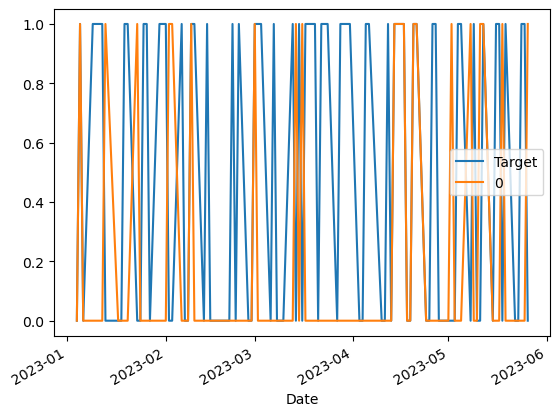

In [41]:
combined.plot()

In [42]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [43]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []
    
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [44]:
predictions = backtest(sp500, model, predictors)

In [45]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors += [ratio_column, trend_column]

In [46]:
sp500 = sp500.dropna()

In [47]:
model = RandomForestClassifier(n_estimators=300, min_samples_split=70, random_state=1)

In [48]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=0.6] = 1
    preds[preds < 0.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [49]:
predictions = backtest(sp500, model, new_predictors)

In [50]:
predictions["Predictions"].value_counts()

0.0    4204
1.0     711
Name: Predictions, dtype: int64

In [51]:
precision_score(predictions["Target"], predictions["Predictions"])

0.569620253164557